This notebook analyzes and generates plots from `results.df`, which contains various measurements of various clustering methods run on all 1070 Scottish elections.

The notebook contains 1 row for each (election, clustering method) pair.
It has the following columns:
- "filename"
- "num_cands"
- "parties" = dictionary mapping candidate number (1-n) to party abreviation.
- "method" = one of {"meanBC", "meanBA", "meanH", "medoBC", "medoBA", "medoH", "slate", "slate_weak"}
- "sil" = silhouette score (all scores are with respect to HH embedding)
- "cal" = calinski harabasz score
- "dav" = davies bouldin score
- "centers" = dictionary {0:center0,1:center1} where "center" means centroid/medoid/slate, depending on the method.
- "clustering" = dictionary {0:cluster0,1:cluster1} where each cluster is a dictionary matching ballots to weights.

The code below adds the following additional columns:
- "bloc_size" = the portion of the ballots in the smaller of the two clusters
- "location", "year", "ward" = separates out the info contained in the filename. 
- "slates" (only in rows with method=='slate') = slates listed by party rather than by candidate name.

In [24]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import MDS 
import glob
import math
import re
from Clustering_Functions import *
import itertools
import os

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
df = pd.read_pickle('results_2025.pkl')

In [3]:
# add column 'bloc_size' = minimum of the two bloc sizes.
ls = []
for row in range(len(df)):
    C = df['clustering'][row]
    a = sum(C[0].values())
    b = sum(C[1].values())
    ls.append(min(a,b)/(a+b))
df['bloc_size'] = ls

c:\Users\ktapp\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


<Axes: xlabel='bloc_size', ylabel='Density'>

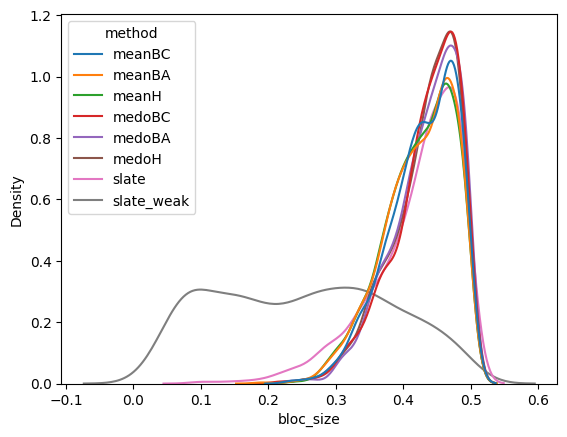

In [7]:
sns.kdeplot(df, x='bloc_size', hue='method')

Measure the average over the elections of the closeness of each pair of methods and create an MDS plot of the result

In [26]:
method_list = ["meanBC", "meanBA", "meanH", "medoBC", "medoBA", "medoH", "slate", "slate_weak"]
full_filename_list = glob.glob("scot-elex/**/*.csv")
filename_list = [os.path.basename(x) for x in full_filename_list]

election_to_closssness = dict() # dictionary mapping the election filename to a dictionary mapping method pairs to closeness

for full_filename in full_filename_list:
    num_cands, election, cand_names, location = csv_parse(full_filename)
    filename = os.path.basename(full_filename)
    # print(filename)

    # create dictionary mapping method to clustering
    method_pair_to_clustering = dict()
    for method in method_list:
        method_pair_to_clustering[method] = df[(df['filename'] == filename) & (df['method'] == method)]['clustering'].values[0]

    # create dictionary mapping method pair to closeness
    pair_to_closeness = dict()
    for m1, m2 in itertools.combinations(method_list,2):
        C1 = method_pair_to_clustering[m1]
        C2 = method_pair_to_clustering[m2]
        pair_to_closeness[(m1,m2)] = Clustering_closeness(election,C1,C2) 

    election_to_closssness[filename] = pair_to_closeness

method_list = ["meanBC", "meanBA", "meanH", "medoBC", "medoBA", "medoH", "slate"] # remove 'slate_weak'
# make dataframe of average closeness of each pair of methods
avg_closeness = pd.DataFrame(columns=method_list, index=method_list)
for m1, m2 in itertools.combinations(method_list, 2):
    avg_closeness.loc[m1,m2] = np.mean([election_to_closssness[filename][(m1,m2)] for filename in filename_list])

# make it into a skey symmetric matrix
for m1, m2 in itertools.product(method_list, method_list):
    if m1 == m2:
        avg_closeness.loc[m1,m2] = 0
    elif pd.isna(avg_closeness.loc[m1,m2]):
        avg_closeness.loc[m1,m2] = avg_closeness.loc[m2,m1]

avg_closeness

,meanBC,meanBA,meanH,medoBC,medoBA,medoH,slate
meanBC,0,0.015595,0.017068,0.071109,0.085867,0.069813,0.120705
meanBA,0.015595,0,0.00421,0.07223,0.083655,0.069904,0.123087
meanH,0.017068,0.00421,0,0.071795,0.082613,0.068903,0.124164
medoBC,0.071109,0.07223,0.071795,0,0.067121,0.0444,0.156096
medoBA,0.085867,0.083655,0.082613,0.067121,0,0.078688,0.177314
medoH,0.069813,0.069904,0.068903,0.0444,0.078688,0,0.155271
slate,0.120705,0.123087,0.124164,0.156096,0.177314,0.155271,0


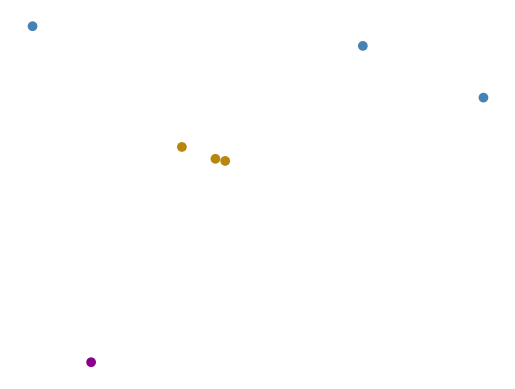

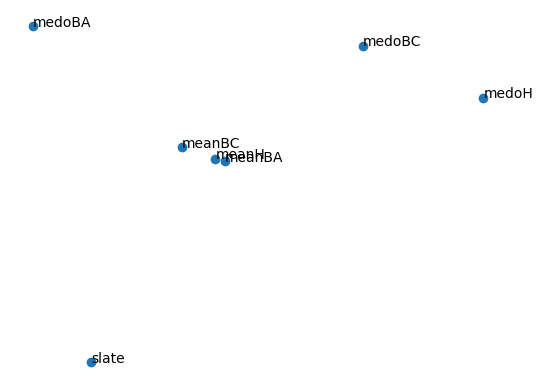

In [27]:
# Create MDS plot of the distances between the methods
projections = MDS(n_components=2, dissimilarity='precomputed').fit_transform(avg_closeness)
X = np.array([p[0] for p in projections])
Y = np.array([p[1] for p in projections])

fig, ax = plt.subplots()
ax.scatter(X,Y, c = ['darkgoldenrod','darkgoldenrod','darkgoldenrod','steelblue','steelblue','steelblue','darkmagenta'])
ax.grid(False)
ax.axis('off')
#plt.savefig("plots/method_MDS_unlabled", dpi = 600)
plt.show()

fig, ax = plt.subplots()
ax.scatter(X,Y)
for count in range(len(method_list)):
    ax.annotate(method_list[count], xy=(X[count], Y[count]))
ax.grid(False)
ax.axis('off')
#plt.savefig("plots/method_MDS_labeled", dpi = 600)
plt.show()

In [28]:
# add columns 'year','location', 'ward' from the separate parts of the filename
def parse_filename(filename):
    # Split the filename and remove the '.csv' extension
    parts = filename[:-4].split('_')
    
    # Find the year, which is a 4-digit number
    for i, part in enumerate(parts):
        if part.isdigit() and len(part) == 4:
            year_index = i
            break
    else:
        return None  # Return None if no 4-digit year is found

    # Join parts before the year as location and parts after the year as sublocation
    location = ' '.join(parts[:year_index])
    year = int(parts[year_index])
    sublocation = ' '.join(parts[year_index + 1:])
    
    return location, year, sublocation

def parse_filename(filename):
    # Split the filename and remove the '.csv' extension
    parts = filename[:-4].split('_')
    
    # Find the year, which is a 4-digit number
    for i, part in enumerate(parts):
        if part.isdigit() and len(part) == 4:
            year_index = i
            break
    else:
        return None  # Return None if no 4-digit year is found

    # Join parts before the year as location and parts after the year as sublocation
    location = ' '.join(parts[:year_index])
    year = int(parts[year_index])
    sublocation = ' '.join(parts[year_index + 1:])
    
    return location, year, sublocation

ls_location = []
ls_year = []
ls_ward = []
for index in df.index:
    location, year, ward = parse_filename(df['filename'][index])
    ls_location.append(location)
    ls_year.append(year)
    ls_ward.append(ward)
df['location'] = ls_location
df['year'] = ls_year
df['ward'] = ls_ward

In [10]:
# list of elections, list of clustering methods
filenames = df['filename'].unique()
method_list = df['method'].unique()

In [11]:
dfs = df[df['method']=='slate'] # only the slate trial of each election
# note that dfs has one row for each election, and hense is good for gathering data that doesn't involve clustering.

In [13]:
df.columns

Index(['filename', 'num_cands', 'parties', 'method', 'block_size', 'sil',
       'cal', 'dav', 'centers', 'clustering', 'bloc_size', 'location', 'year',
       'ward'],
      dtype='object')

In [14]:
# add 'slates' column to dfs containing the slates listed by party
slates = []
for index in dfs.index:
    centers = dfs['centers'][index]
    parties = dfs['parties'][index]
    slate = {i:tuple([parties[cand] for cand in center]) for i,center in centers.items()}
    slates.append(slate)
dfs['slates'] = slates

C:\Users\ktapp\AppData\Local\Temp\ipykernel_19036\568740969.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs['slates'] = slates


C:\Users\ktapp\AppData\Local\Temp\ipykernel_19036\1207206529.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs['slate_size'] = ls


<Axes: >

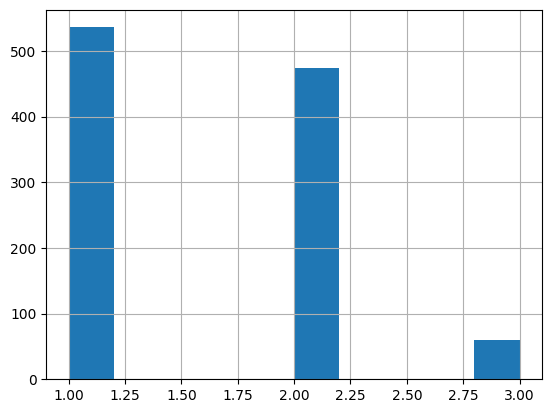

In [53]:
# Study the distribution of slate sizes

# add column 'slate_size' = size of the slate
ls = []
for index in dfs.index:
    slates = dfs['slates'][index]
    l = [len(slate) for slate in slates.values()]
    ls.append(min(l))
dfs['slate_size'] = ls

dfs['slate_size'].hist()

<Axes: xlabel='num_cands', ylabel='slate_size'>

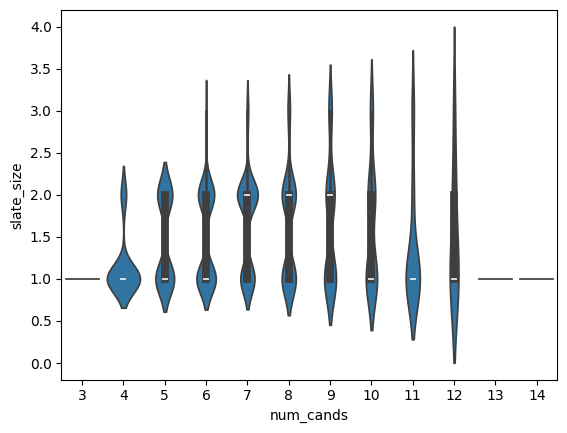

In [57]:
sns.violinplot(data=dfs, x='num_cands', y='slate_size')

C:\Users\ktapp\AppData\Local\Temp\ipykernel_19036\3088907174.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfw['slate_size'] = ls


<Axes: >

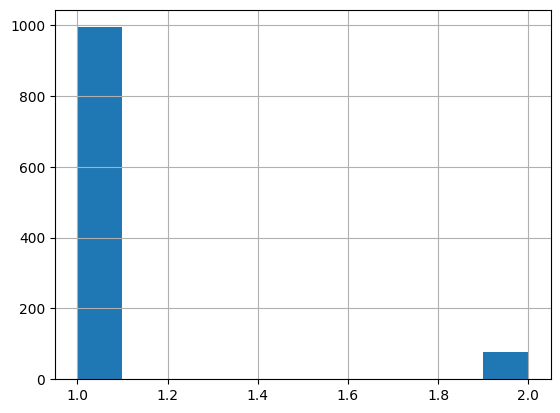

In [59]:
# do the same for the weak slate method
dfw = df[df['method']=='slate_weak']
ls = []
for index in dfw.index:
    slates = dfw['centers'][index]
    l = [len(slate) for slate in slates.values()]
    ls.append(min(l))
dfw['slate_size'] = ls

dfw['slate_size'].hist()

<Axes: xlabel='num_cands', ylabel='slate_size'>

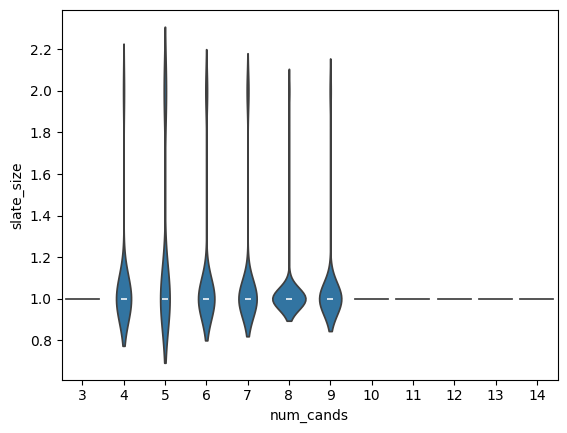

In [60]:
sns.violinplot(data=dfw, x='num_cands', y='slate_size')

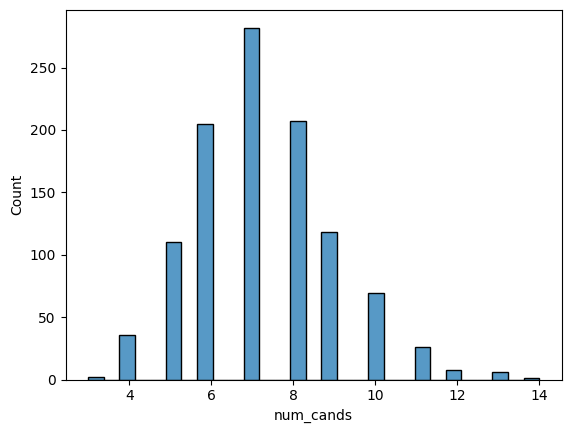

In [29]:
fig = sns.histplot(dfs, x='num_cands')
# fig.figure.savefig("plots/num_cands.jpg", dpi = 600)

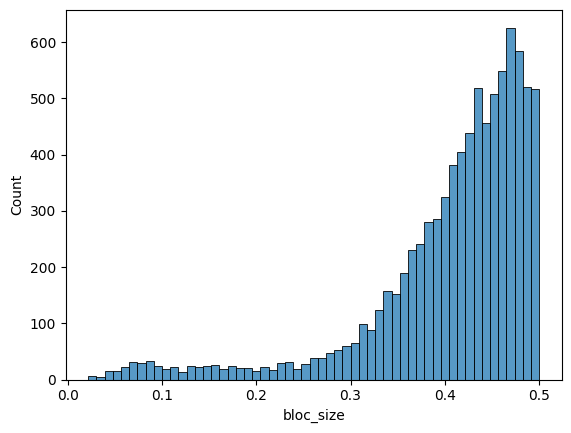

In [30]:
fig = sns.histplot(data = df, x = 'bloc_size')
#fig.figure.savefig("plots/block_size.jpg", dpi = 600)

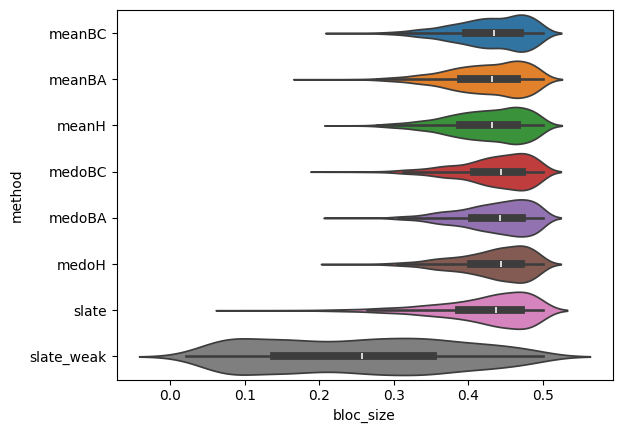

In [31]:
fig = sns.violinplot(data = df, x = 'bloc_size', y='method', hue='method')
#fig.figure.savefig("plots/sperm_race.jpg", dpi = 600)

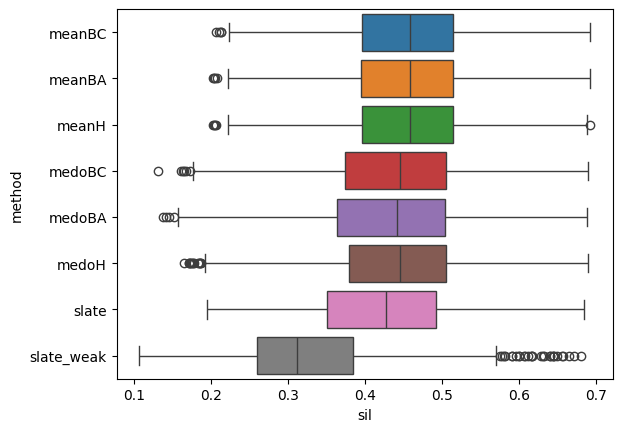

In [32]:
fig = sns.boxplot(data=df, x='sil',y='method', hue = 'method')
#fig.figure.savefig("plots/sil.jpg", dpi = 600)

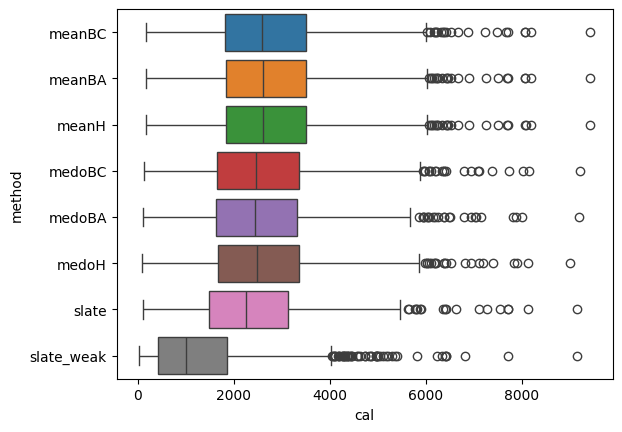

In [33]:
fig = sns.boxplot(data=df, x='cal',y='method', hue = 'method')
# fig.figure.savefig("plots/cal.jpg", dpi = 600)

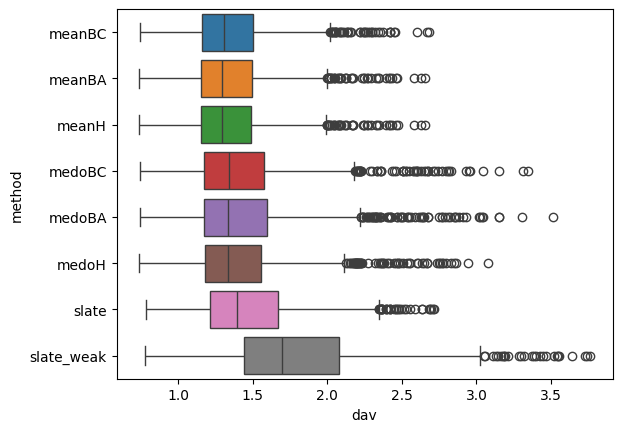

In [35]:
fig = sns.boxplot(data=df, x='dav',y='method', hue = 'method')
#fig.figure.savefig("plots/dav.jpg", dpi = 600)

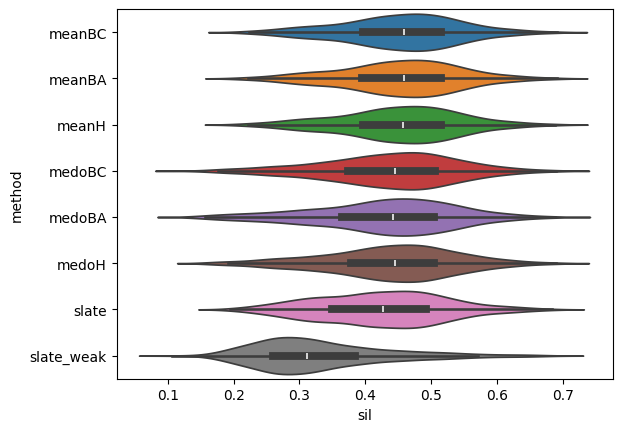

In [34]:
fig = sns.violinplot(data=df, x = 'sil', y = 'method', hue = 'method')
#fig.figure.savefig("plots/methd_vs_sil_violin.jpg", dpi = 600)

<Axes: xlabel='year', ylabel='Count'>

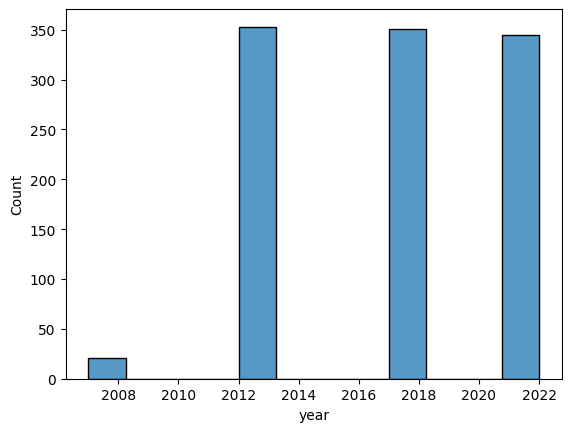

In [36]:
sns.histplot(dfs,x='year')

In [37]:
dfs['year'].unique()

array([2017, 2022, 2012, 2007], dtype=int64)

In [38]:
dfs['location'].unique() # The 32 "Council Areas", also called "Local Authority Areas"

array(['aberdeen', 'aberdeenshire', 'angus', 'argyll bute', 'dumgal',
       'dundee', 'east renfrewshire', 'edinburgh', 'eilean siar',
       'falkirk', 'fife', 'glasgow', 'highland', 'moray',
       'north ayrshire', 'north lanarkshire', 'renfrewshire',
       'south lanarkshire', 'stirling', 'west lothian', 'orkney',
       'clackmannanshire', 'east ayrshire', 'east dunbartonshire',
       'midlothian', 'sc borders', 'shetland', 'south ayrshire',
       'east lothian', 'inverclyde', 'perth kinross',
       'west dunbartonshire'], dtype=object)

In [42]:
# gather the set of all parties in all elections
set_of_all_parties = set()
for index in dfs.index:
    set_of_all_parties = set_of_all_parties.union(set(dfs['parties'][index].values()))

# create a dictionary matching party codes to the portion of total Borda points
# received by all candidates from that party in all elections.
party_to_borda={code:0 for code in set_of_all_parties}
filename_list = glob.glob("scot-elex/**/*.csv")

for filename in filename_list:
    num_cands, election, cand_names, location = csv_parse(filename)
    party_list = party_abrevs(cand_names)
    for ballot, weight in election.items():
        for position in range(len(ballot)):
            party = party_list[ballot[position]-1]
            party_to_borda[party] += weight*(num_cands-position-1)

# scale the values to become percentage of all Borda points
total_weight = sum(party_to_borda.values())
for code, weight in party_to_borda.items():
    party_to_borda[code] = 100*weight/total_weight

# print the parties sorted by total Borda weight
def print_sorted(input_dict):
    # Sort the dictionary by values
    sorted_items = sorted(input_dict.items(), key=lambda item: item[1], reverse=True)
    
    # Print the sorted dictionary
    for key, value in sorted_items:
        print(f"{key}: {value}")

print_sorted(party_to_borda)

SNP: 28.74765729404872
Lab: 23.95570444169389
Con: 13.50953205501675
Ind: 11.73632225338278
LD: 9.697650822488496
Gr: 7.249022670196341
LabCo: 0.9456701075769515
API: 0.563822752349618
Soc: 0.5533707283015901
Sol: 0.4491702130287654
UKIP: 0.39472722068880634
SFP: 0.3624418752798889
TUSC: 0.3587408834899952
Glasgow First: 0.17097708000396458
SU: 0.1471126985122634
Libtn: 0.1456049296382576
SLP: 0.0970089982864339
SSC: 0.09473756920469367
SC: 0.08901011764668539
IANL: 0.07417049767620729
WDuns: 0.06980360338589454
ISP: 0.06901234100197694
Borders: 0.06755172584561739
Lib: 0.041804645920088986
FA: 0.036243957509854034
WEP: 0.032968499269450904
NRMUPB: 0.03142162731251895
SDP: 0.027334205056060826
CICA: 0.02703633157141742
BNP: 0.025651622399561605
EDIA: 0.023974790196433875
Rubbish: 0.02321918062341953
Volt: 0.018774080167254466
EKA: 0.018453204869125085
Pir: 0.016772922393974463
CPA: 0.01608516817074375
NF: 0.015609030631584024
Comm: 0.013730932560453999
OMG: 0.013239843842528388
Sov: 0.

In [43]:
len(party_to_borda)

49

In [44]:
top_parties = ['SNP', 'Lab', 'Ind', 'Con', 'LD', 'Gr']
scores = [party_to_borda[code] for code in top_parties]
top_parties.append('other')
scores.append(sum(x for x in party_to_borda.values() if x<=1))
D = {'SNP':'yellow', 'Lab': 'red', 'Con':'blue','LD':'orange','Gr':'green', "Ind":'black', 'other':'white'}
colors = [D[party] for party in top_parties]

Text(0.5, 1.0, 'Portion of total Borda points')

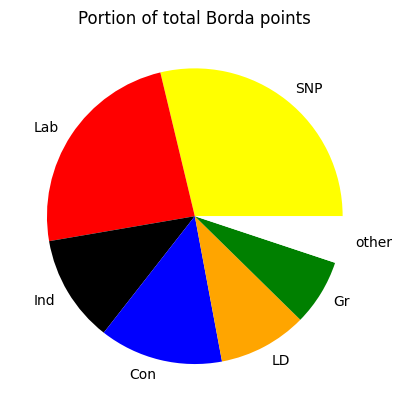

In [45]:
plt.pie(scores, labels = top_parties, colors=colors)
plt.title('Portion of total Borda points')
#plt.savefig("plots/pie.jpg", dpi = 600)

In [46]:
# Create table showing the number of number of total first-place-votes (over all elections)
# received by each major party.

data_dict = {party_code:0 for party_code in top_parties}
filename_list = glob.glob("scot-elex/**/*.csv")

for filename in filename_list:
    num_cands, election, cand_names, location = csv_parse(filename)
    party_list = party_abrevs(cand_names)
    for ballot, weight in election.items():
        party = party_list[ballot[0]-1]
        if party in ['SNP', 'Lab', 'Ind', 'Con', 'LD', 'Gr']:
            data_dict[party]+=weight
        else:
            data_dict['other']+=weight

total = sum(data_dict.values())
for party in data_dict:
    data_dict[party] /= total

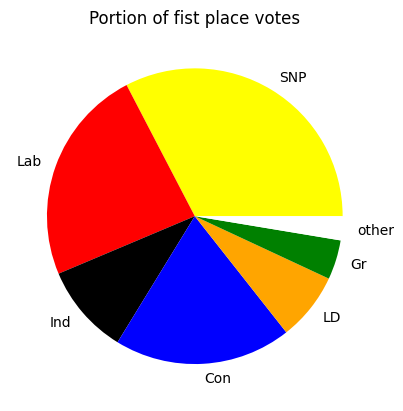

In [47]:
plt.pie(data_dict.values(), labels = top_parties, colors=colors)
#plt.title("Portion of first place votes")
plt.title('Portion of fist place votes')
plt.savefig("plots/pie_2.jpg", dpi = 600)

In [48]:
# Create table showing the number of elections in which each major party ran each number of candidates.

top_parties = ['SNP', 'Lab', 'Ind', 'Con', 'LD', 'Gr']
data = np.zeros((6,11))
filename_list = glob.glob("scot-elex/**/*.csv")

for filename in filename_list:
    num_cands, election, cand_names, location = csv_parse(filename)
    party_list = party_abrevs(cand_names)
    for party_index in range(len(top_parties)):
        party = top_parties[party_index]
        count = party_list.count(party)
        data[party_index,count] +=1

trunc_data = data[:,:8]
pf = pd.DataFrame(trunc_data, index = top_parties, columns=range(8))
# pf.to_csv('tables\How_many_candidates_does_the_party_run.csv')
pf


,0,1,2,3,4,5,6,7
SNP,32.0,322.0,658.0,57.0,1.0,0.0,0.0,0.0
Lab,166.0,465.0,405.0,34.0,0.0,0.0,0.0,0.0
Ind,427.0,323.0,153.0,83.0,31.0,25.0,13.0,9.0
Con,55.0,867.0,138.0,10.0,0.0,0.0,0.0,0.0
LD,332.0,700.0,36.0,2.0,0.0,0.0,0.0,0.0
Gr,508.0,562.0,0.0,0.0,0.0,0.0,0.0,0.0
